In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/") 

In [0]:
from envs.blackjack import BlackjackEnv
import plotting

import gym
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

## Evaluate the Policy

- Using Monte Carlo prediction algorithm.(使用MC方法)
- Calculates the value function for a given policy using sampling. (对给定的policy进行评价, 也就是计算出value function/)
    

### 初始化环境

In [0]:
environment = BlackjackEnv()

### 定义一个policy

在这里我们定义一个policy为了方便对这个环境的了解. 

这个policy就是当我们手上牌的总和>18就不要牌, 否则就要牌. 

In [0]:
def strategy(observation):
    score, dealer_score, usable_ace = observation
    if score >= 20:
        return 0
    else:
        return 1

### 评价上面的Policy

需要注意, 这里的reward不是当前步骤的奖励, 而是到最后结束的累计奖励(后面的乘上$\gamma$), 因为是做了完整的实验, 所以我们是可以知道从这一步后面获得的奖励的.

在一个episode的时候, 我们需要把每一步的结果都记录下来, 放在episode数组里面.

In [0]:
episode = [] 
state = environment._reset()
for t in range(100):
    action = strategy(state) # state就是observation包含(score, dealer_score, usable_ace)
    next_state, reward, done, _ = environment._step(action)
    episode.append((state, action, reward))
    if done:
        break
    state = next_state

In [16]:
# 玩一轮, 会记录下这一轮下的state和对应的reward
episode

[((15, 8, False), 1, 0), ((20, 8, False), 0, 1)]

In [0]:
# 这一轮下所有的状态
states_in_episode = set([tuple(x[0]) for x in episode])
states_in_episode

{(14, 8, False), (19, 8, False)}

In [0]:
# 找到某个state是在什么时候出现的
first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == (14, 8, False))
first_occurence_idx

0

In [0]:
# Sum up all rewards since the first occurance
discount_factor = 0.9
print('first_occurence_idx"{}'.format(first_occurence_idx))
G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
G # 这里就是累计和, 0+0.9*(-1)=-0.9

first_occurence_idx"0


-0.9

### 完整的函数

In [0]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """使用MC的方法, 对给定的policy进行评价.
    """

    # Keeps track of sum and count of returns for each state to calculate an average. 
    # We could use an array to save all returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float) # 记录一个state总的reward
    returns_count = defaultdict(float) # 没有key的时候, 默认返回0
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env._reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env._step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # 找到每个状态在整个episode第一次出现的位置
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # 计算G, 也就是累计reward
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

### 评价上面的policy且进行可视化

Episode 500000/500000.

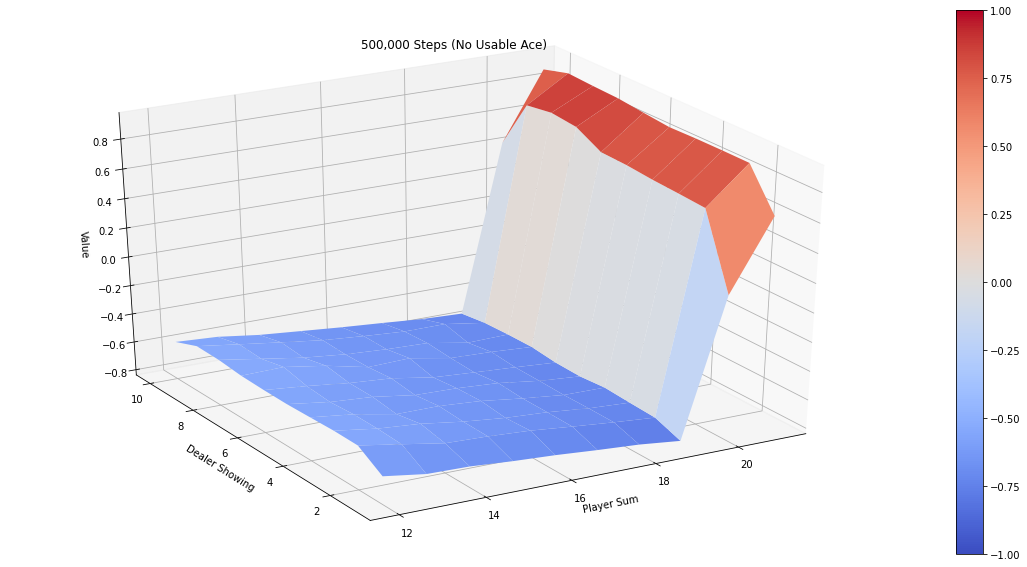

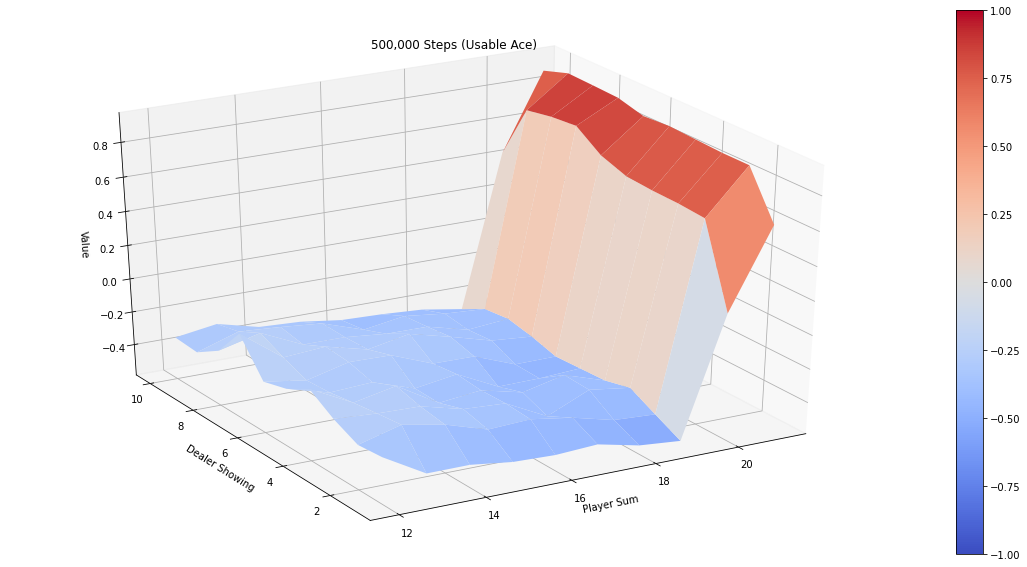

In [23]:
V_500k = mc_prediction(strategy, environment, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

In [24]:
V_500k

defaultdict(float,
            {(12, 1, False): -0.6406926406926406,
             (12, 1, True): -0.3065326633165829,
             (12, 2, False): -0.5301518438177875,
             (12, 2, True): -0.3203463203463203,
             (12, 3, False): -0.5277656318320945,
             (12, 3, True): -0.25213675213675213,
             (12, 4, False): -0.5339149400218103,
             (12, 4, True): -0.1583710407239819,
             (12, 5, False): -0.5393428447903156,
             (12, 5, True): -0.24017467248908297,
             (12, 6, False): -0.5376975169300225,
             (12, 6, True): -0.28,
             (12, 7, False): -0.5324360105913504,
             (12, 7, True): -0.07346938775510205,
             (12, 8, False): -0.5151119808654055,
             (12, 8, True): -0.256,
             (12, 9, False): -0.5112781954887218,
             (12, 9, True): -0.3453815261044177,
             (12, 10, False): -0.5740587619205115,
             (12, 10, True): -0.33410672853828305,
            